In [51]:
#! /usr/bin/env python
'''
    code for gaussian mixture solver
    based on Kalai STOC'10 paper
    Efficiently learning mixtures of two gaussians
'''
from __future__ import division
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy.stats import norm
%matplotlib inline 

In [ ]:
class TwoGaussian(object):
    def __init__(self, sample):
        self.M1 = np.mean(sample)
        self.M2 = np.mean(sample**2)
        self.M3 = np.mean(sample**3)
        self.M4 = np.mean(sample**4)
        self.M5 = np.mean(sample**5)
        self.M6 = np.mean(sample**6)
        self.x3 = self.M3
        self.x4 = self.M4 - 3* self.M2**2
        self.x5 = self.M5 - 10 * self.M3 * self.M2
        self.x6 = self.M6 - 15 * self.M4 * self.M2 + 30 * self.M2**3
        self.alpha
        self.gamma
        self.beta
        
    def recoverAlphaFromMoment(self, eps):
        X3, X4, X5, X6 = [self.x3, self.x4, self.x5, self.x6]
        coeff = [2, X4, -X3**2]
        ymax = np.max(np.roots(coeff))
        kai = 1 + np.sqrt(np.abs(X4))/ymax
        #remove 18th degree polynomial for reference in later session
        
        #only keep cofficients of the first derivative of r(y)
        coeff= rprime(self, X3, X4, X5, X6)
        R = np.roots(coeff)
        candidates = np.append(R, (1+eps/kai)*ymax)
        alphaOPT = float('-inf')
        thred1 = (1+eps/kai)*ymax
        thred2 = (eps**2)*(kai**10)
        small_candidates = candidates[candidates <= thred1]
        res = [x for x in small_candidates if ry(x) <= thred2*x**18]
        assert len(res) > 0 'no valid solution for alpha'
        return np.max(res)
            
            
        
        return ymax
    def ry(self, y):
        X3, X4, X5, X6 = [self.x3, self.x4, self.x5, self.x6]
        ry = 80*X3**12 - 640*X3**10*X4*y + 1984*X3**10*y**3 + \
        464*X3**9*X5*y**2 + 1720*X3**8*X4**2*y**2 - 10880*X3**8*X4*y**4 - \
        32*X3**8*X6*y**3 + 11872*X3**8*y**6 - 2488*X3**7*X4*X5*y**3 + \
        6096*X3**7*X5*y**5 - 1640*X3**6*X4**3*y**3 + 17920*X3**6*X4**2*y**5 + \
        152*X3**6*X4*X6*y**4 - 33888*X3**6*X4*y**7 + 772*X3**6*X5**2*y**4 - \
        432*X3**6*X6*y**6 - 6144*X3**6*y**9 + 3796*X3**5*X4**2*X5*y**4 - \
        17712*X3**5*X4*X5*y**6 - 80*X3**5*X5*X6*y**5 + 3088*X3**5*X5*y**8 + \
        130*X3**4*X4**4*y**4 - 9320*X3**4*X4**3*y**6 - 200*X3**4*X4**2*X6*y**5 + \
        31184*X3**4*X4**2*y**8 - 2252*X3**4*X4*X5**2*y**5 + 848*X3**4*X4*X6*y**7 + \
        16480*X3**4*X4*y**10 + 2264*X3**4*X5**2*y**7 + 16*X3**4*X6**2*y**6 + 512*X3**4*X6*y**9 + \
        3872*X3**4*y**12 - 1322*X3**3*X4**3*X5*y**5 + 14500*X3**3*X4**2*X5*y**7 + \
        116*X3**3*X4*X5*X6*y**6 - 3544*X3**3*X4*X5*y**9 + 288*X3**3*X5**3*y**6 + \
        56*X3**3*X5*X6*y**8 + 112*X3**3*X5*y**11 + 300*X3**2*X4**5*y**5 - 400*X3**2*X4**4*y**7 + \
        102*X3**2*X4**3*X6*y**6 - 10144*X3**2*X4**3*y**9 + 1597*X3**2*X4**2*X5**2*y**6 - \
        556*X3**2*X4**2*X6*y**8 - 14080*X3**2*X4**2*y**11 - 3476*X3**2*X4*X5**2*y**8 - \
        24*X3**2*X4*X6**2*y**7 - 728*X3**2*X4*X6*y**10 - 6208*X3**2*X4*y**13 + 436*X3**2*X5**2*y**10 - \
        16*X3**2*X6**2*y**9 - 208*X3**2*X6*y**12 - 768*X3**2*y**15 - 606*X3*X4**4*X5*y**6 - \
        2024*X3*X4**3*X5*y**8 - 42*X3*X4**2*X5*X6*y**7 - 1056*X3*X4**2*X5*y**10 - \
        432*X3*X4*X5**3*y**7 - 40*X3*X4*X5*X6*y**9 + 544*X3*X4*X5*y**12 + 288*X3*X5**3*y**9 - \
        8*X3*X5*X6*y**11 + 352*X3*X5*y**14 + 90*X4**6*y**6 + 408*X4**5*y**8 - 18*X4**4*X6*y**7 + \
        1720*X4**4*y**10 + 108*X4**3*X5**2*y**7 + 120*X4**3*X6*y**9 + 3008*X4**3*y**12 + \
        360*X4**2*X5**2*y**9 + 9*X4**2*X6**2*y**8 + 256*X4**2*X6*y**11 + 2400*X4**2*y**14 + \
        336*X4*X5**2*y**11 + 12*X4*X6**2*y**10 + 160*X4*X6*y**13 + 896*X4*y**16 + 36*X5**4*y**8 + \
        96*X5**2*y**13 + 4*X6**2*y**12 + 32*X6*y**15 + 128*y**18
        return ry
    def rprime(self, X3, X4, X5, X6):
        res = [2304,
 0,
 14336*X4,
 -11520*X3**2 + 480*X6,
 4928*X3*X5 + 33600*X4**2,
 -80704*X3**2*X4 + 2080*X4*X6 + 1248*X5**2,
 46464*X3**4 - 2496*X3**2*X6 + 6528*X3*X4*X5 + 36096*X4**3 + 48*X6**2,
 1232*X3**3*X5 - 154880*X3**2*X4**2 - 88*X3*X5*X6 + 2816*X4**2*X6 + 3696*X4*X5**2,
 164800*X3**4*X4 - 7280*X3**2*X4*X6 + 4360*X3**2*X5**2 - 10560*X3*X4**2*X5 + 17200*X4**4 + 120*X4*X6**2,
 -55296*X3**6 + 4608*X3**4*X6 - 31896*X3**3*X4*X5 - 91296*X3**2*X4**3 - 144*X3**2*X6**2 - 360*X3*X4*X5*X6 + 2592*X3*X5**3 + 1080*X4**3*X6 + 3240*X4**2*X5**2,
 24704*X3**5*X5 + 249472*X3**4*X4**2 + 448*X3**3*X5*X6 - 4448*X3**2*X4**2*X6 - 27808*X3**2*X4*X5**2 - 16192*X3*X4**3*X5 + 3264*X4**5 + 72*X4**2*X6**2 + 288*X5**4,
 -237216*X3**6*X4 + 5936*X3**4*X4*X6 + 15848*X3**4*X5**2 + 101500*X3**3*X4**2*X5 - 2800*X3**2*X4**4 - 168*X3**2*X4*X6**2 - 294*X3*X4**2*X5*X6 - 3024*X3*X4*X5**3 - 126*X4**4*X6 + 756*X4**3*X5**2,
 71232*X3**8 - 2592*X3**6*X6 - 106272*X3**5*X4*X5 - 55920*X3**4*X4**3 + 96*X3**4*X6**2 + 696*X3**3*X4*X5*X6 + 1728*X3**3*X5**3 + 612*X3**2*X4**3*X6 + 9582*X3**2*X4**2*X5**2 - 3636*X3*X4**4*X5 + 540*X4**6,
 30480*X3**7*X5 + 89600*X3**6*X4**2 - 400*X3**5*X5*X6 - 1000*X3**4*X4**2*X6 - 11260*X3**4*X4*X5**2 - 6610*X3**3*X4**3*X5 + 1500*X3**2*X4**5,
 -43520*X3**8*X4 + 608*X3**6*X4*X6 + 3088*X3**6*X5**2 + 15184*X3**5*X4**2*X5 + 520*X3**4*X4**4,
 5952*X3**10 - 96*X3**8*X6 - 7464*X3**7*X4*X5 - 4920*X3**6*X4**3,
 928*X3**9*X5 + 3440*X3**8*X4**2,
 -640*X3**10*X4]
        return res

In [109]:
#! /usr/bin/python
# Setup variables and expressions
from sympy import *
alpha = Symbol(r'\alpha')
beta = Symbol(r'\beta')
gamma = Symbol(r'\gamma')
X3 = Symbol('X3')
X4 = Symbol('X4')
X5 = Symbol('X5')
X6 = Symbol('X6')
y = Symbol('y')
#X3 = alpha * beta + 3 * alpha * gamma
#X4 = -2*alpha**2 + alpha*beta**2 + 6*alpha*beta*gamma + 3*alpha*gamma**2
#X5 = alpha * (beta**3 - 8*alpha*beta + 10*beta**2*gamma + 15*gamma**2*beta
#- 20*alpha*gamma)
#X6 = alpha*(16*alpha**2 - 12*alpha*beta**2 + beta**4 + 45*beta**2*gamma**2 +
#15*beta*gamma**3 + 15*gamma*(-4*alpha*beta + beta**3))
p5 = (6*(2*X3*y**3 + X5*y**2 - 3*X3*X4*y + 2*X3**3)**2 +
(2*y**3+3*X4*y - 4*X3**2)**2*(2*y**3 + X4*y - X3**2))**2
p6 = ((4*X3**2 - 3*X4*y - 2*y**3) *
(4*X3**4 - 4*X3**2*X4*y - 8*X3**2*y**3 - X4**2*y**2 +
8*X4*y**4 + X6*y**3 + 4*y**6) -
(10*X3**3 - 7*X3*X4*y - 2*X3*y**3) *
(2*X3**3 - 3*X3*X4*y + 2*X3*y**3 + X5*y**2))**2
r = p5+p6
rprime = diff(r, y)
#rprimePoly = Poly(rprime, y)
#rprimePoly.all_coeffs()
r.expand()

80*X3**12 - 640*X3**10*X4*y + 1984*X3**10*y**3 + 464*X3**9*X5*y**2 + 1720*X3**8*X4**2*y**2 - 10880*X3**8*X4*y**4 - 32*X3**8*X6*y**3 + 11872*X3**8*y**6 - 2488*X3**7*X4*X5*y**3 + 6096*X3**7*X5*y**5 - 1640*X3**6*X4**3*y**3 + 17920*X3**6*X4**2*y**5 + 152*X3**6*X4*X6*y**4 - 33888*X3**6*X4*y**7 + 772*X3**6*X5**2*y**4 - 432*X3**6*X6*y**6 - 6144*X3**6*y**9 + 3796*X3**5*X4**2*X5*y**4 - 17712*X3**5*X4*X5*y**6 - 80*X3**5*X5*X6*y**5 + 3088*X3**5*X5*y**8 + 130*X3**4*X4**4*y**4 - 9320*X3**4*X4**3*y**6 - 200*X3**4*X4**2*X6*y**5 + 31184*X3**4*X4**2*y**8 - 2252*X3**4*X4*X5**2*y**5 + 848*X3**4*X4*X6*y**7 + 16480*X3**4*X4*y**10 + 2264*X3**4*X5**2*y**7 + 16*X3**4*X6**2*y**6 + 512*X3**4*X6*y**9 + 3872*X3**4*y**12 - 1322*X3**3*X4**3*X5*y**5 + 14500*X3**3*X4**2*X5*y**7 + 116*X3**3*X4*X5*X6*y**6 - 3544*X3**3*X4*X5*y**9 + 288*X3**3*X5**3*y**6 + 56*X3**3*X5*X6*y**8 + 112*X3**3*X5*y**11 + 300*X3**2*X4**5*y**5 - 400*X3**2*X4**4*y**7 + 102*X3**2*X4**3*X6*y**6 - 10144*X3**2*X4**3*y**9 + 1597*X3**2*X4**2*X5**2*y**6 

[9, 3, 1]

In [3]:
def univariate_est(eps, delta, SAF):
    '''
        univariate estimation for two guassian mmixture
        ----
        return (w_i, mu_i, sigma_i) for i = 1, 2
    '''
    M = [0]*6
    M[1] = 1
    alpha = eps**150
    m = np.ceil(500**2/(alpha**2*delta))
    N = np.ceil(1/(alpha * epsilon**3))
    sampleM = np.random.choice(SAF, m, replace=True)
    for i in np.arange(6)[2:]:
        M[i] = np.mean(sampleM**(i+1))
    A = np.arange(N)[1:]/N
    B = np.arange(2*N+1)/N-N
    
        

In [4]:
def moment(mu, sigma, order):
    '''
        gaussian moment calculation
        ---
        mu:
        sigma:
        order: optional value range 1, 2, 3, 4, 5, 6
        ---
        return moment value with corresponding order
    '''
    if order == 1:
        return mu
    if order == 2:
        return mu**2+sigma**2
    if order == 3:
        return mu**3 + 3*mu*sigma**2
    if order == 4:
        return mu**4+6*mu**2*sigma**2+3*sigma**4
    if order == 5:
        return mu**5+10*mu**3*sigma**2+15*mu*sigma**4
    if order == 6:
        return mu**6+15*mu**4*sigma**2+45*mu**2*sigma**4 + 15*sigma**6 

In [58]:
x = np.random.normal(0,1, 100)
y = np.append(x, np.random.normal(4, 0.5, 100))
mx = []
for j in np.arange(6):
    mx += [np.mean(x**(j+1))]
mx = np.array(mx)


def loss_abs(x, m=mx):
    mm1=[]
    mm2 = []
    for i in np.arange(6):
        mm1+= [moment(x[1], x[2], i+1)]
        mm2+= [moment(x[3], x[4], i+1)]
    mm = x[0]*np.array(mm1)+(1-x[0])*np.array(mm2)
    return sum((m-mm)**2)

from scipy.optimize import minimize
x0 = np.array([0.5,0,1,4,0.25])
bnds = ((0, 1), (None, None), (None, None), (None, None), (None, None))
#res = minimize(loss_abs, x0, method = "BFGS")

In [59]:
res = minimize(loss_abs, x0, method = 'L-BFGS-B', bounds=bnds)

In [60]:
#loss_abs(x0)

In [61]:
res.x

array([ 0.70498765, -0.44410774,  0.90654254,  1.30307228, -0.5114366 ])

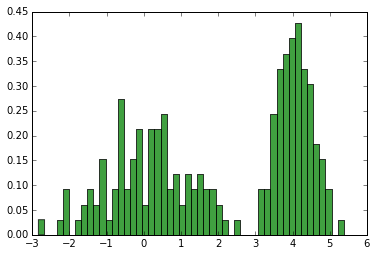

In [62]:
n, bins, patches =plt.hist(y, 50, normed=1, facecolor='green', alpha=0.75)

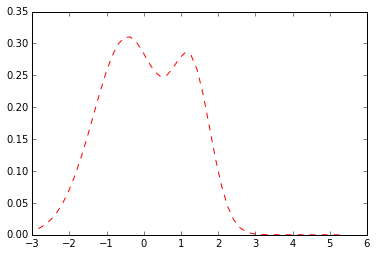

In [64]:
y = res.x[0]*norm.pdf(bins, loc=res.x[1], scale=res.x[2])\
+(1-res.x[0])*norm.pdf(bins, loc=res.x[3], scale=np.abs(res.x[4]))
l = plt.plot(bins, y, 'r--', linewidth=1)
plt.show()

In [101]:
coeff = [1, 2, 1]
a = np.roots(coeff)

In [103]:
np.append(a, 6)

array([-1., -1.,  6.])

In [130]:
a = np.array([1, 2, 3, 4])
if len([x for x in a if (x**2-4*x) <= x-10]) == 0:
    print 'None'
else:
    print 'y'

None


In [133]:
a, b, c = (1, 2, 3)
print a
print b
print c

1
2
3
